## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [31]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [32]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [33]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text_lines = text
text = "".join([line.lower() for line in text])

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [34]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

--2024-12-16 21:59:18--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 262521 (256K) [text/plain]
Сохранение в: «onegin.txt.3»

onegin.txt.3        100%[===================>] 256,37K  --.-KB/s    за 0,1s    

2024-12-16 21:59:18 (2,54 MB/s) - «onegin.txt.3» сохранён [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [35]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()

assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [36]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [37]:
# dict <index>:<char>
# Your great code here

# dict <char>:<index>
# Your great code here
token_to_idx = {char: idx for idx, char in enumerate(tokens)}
idx_to_token = {idx: char for idx, char in enumerate(tokens)}

print(f"Number of tokens: {len(tokens)}")

Number of tokens: 83


*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [38]:
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))

cpu device is available


In [39]:
# Your code here
class RNN(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units

        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)

        h_next = self.rnn_update(x_and_h)
        h_next = torch.tanh(h_next)
        logits = self.rnn_to_logits(h_next)

        return h_next, F.log_softmax(logits, -1)

    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, requires_grad=True).to(device)

In [40]:
text_encoded = [token_to_idx[x] for x in text]

batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int)

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))

def train(model, batch, optimizer, criterion):
    model.zero_grad()
    hidden = model.initial_state(batch_size)
    logprobs = []

    for x_t in batch.transpose(0,1):
        hidden, logits = model(x_t, hidden)
        logprobs.append(logits)

    logprobs = torch.stack(logprobs, dim=1)
    pred = logprobs[:, :-1]
    actual_tokens = batch[:, 1:]

    loss = criterion(
        pred.contiguous().view(-1, len(tokens)),
        actual_tokens.contiguous().view(-1)
    )

    loss.backward()
    optimizer.step()

    return loss

In [47]:
n_epochs = 3000

model = RNN()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

loss_history = []
start_time = time.time()

model.to(device)
model.train()

for epoch in range(1, n_epochs + 1):
    batch = torch.tensor(next(generate_chunk()), dtype=torch.int64)
    loss = train(model, batch.to(device), optimizer, criterion)
    loss_history.append(loss.cpu().detach().numpy())

time_elapsed = time.time() - start_time
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Training complete in 3m 4s


Plot the loss function (axis X: number of epochs, axis Y: loss function).

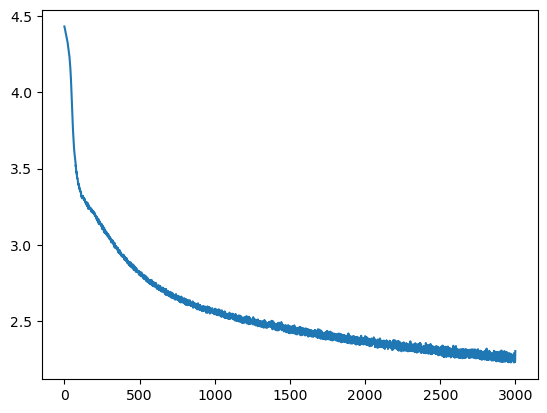

In [48]:
plt.plot(loss_history,label='loss')
plt.show()

In [49]:
torch.save(model, 'rnn')

In [50]:
def generate_sample(model, seed_phrase=" мой дядя ", max_length=500, temperature=1.0, device=device):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function

    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
        smaller temperature converges to the single most likely output.

    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''

    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    hidden = model.initial_state(batch_size=1)
    model.eval()

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hidden, _ = model(x_sequence[:, i], hidden)

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hidden, logp_next = model(x_sequence[:, -1], hidden)
        # Be really careful here with the model output
        p_next = F.softmax(logp_next / temperature, dim=-1).data.cpu().numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64, device=device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

In [51]:
# An example of generated text.
print(generate_sample(model, temperature=0.4))

 мой дядя на сердца сердашал, не умали столовой посторой лень он разновой моет онной посталенье сторо своей любодиной стрый сторой старать своей
и востенной в не помный стой на стразней безна и молодный в плетать пострась леновой на снеша в столов содной
на моло породной
не сердцо постради в сем и верать своей сердце половь подровно столенье поддала содде стала той нажет садет нем оне свена стара скреда но свало в нем и свет не ленный весть она постала просторы
в поэто своров него поранье своей 


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [52]:
# Your beautiful code here
class LSTM(nn.Module):
    def __init__(self, num_tokens=len(token_to_idx), embedding_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units

        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.lstm = nn.LSTMCell(embedding_size, rnn_num_units)
        self.f = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev, c_prev):
        x_emb = self.embedding(x)
        h, c = self.lstm(x_emb, (h_prev, c_prev))
        out = self.f(h)

        return h, c, F.log_softmax(out, -1)

    def initial_state(self, batch_size):
        return (torch.zeros(batch_size, self.num_units, requires_grad=True).to(device),
               torch.zeros(batch_size, self.num_units, requires_grad=True).to(device))

In [53]:
def train_lstm(model, batch, optimizer, criterion):
    model.zero_grad()
    hidden, cell = model.initial_state(batch_size)
    logprobs = []

    for x_t in batch.transpose(0,1):
        hidden, cell, logits = model(x_t, hidden, cell)
        logprobs.append(logits)

    logprobs = torch.stack(logprobs, dim=1)
    pred = logprobs[:, :-1]
    actual_tokens = batch[:, 1:]

    loss = criterion(
        pred.contiguous().view(-1, len(tokens)),
        actual_tokens.contiguous().view(-1)
    )

    loss.backward()
    optimizer.step()

    return loss

In [54]:
n_epochs = 3000

model = LSTM()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

loss_history = []
start_time = time.time()

model.to(device)
model.train()

for epoch in range(1, n_epochs + 1):
    batch = torch.tensor(next(generate_chunk()), dtype=torch.int64)
    loss = train_lstm(model, batch.to(device), optimizer, criterion)
    loss_history.append(loss.cpu().detach().numpy())

time_elapsed = time.time() - start_time
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Training complete in 6m 21s


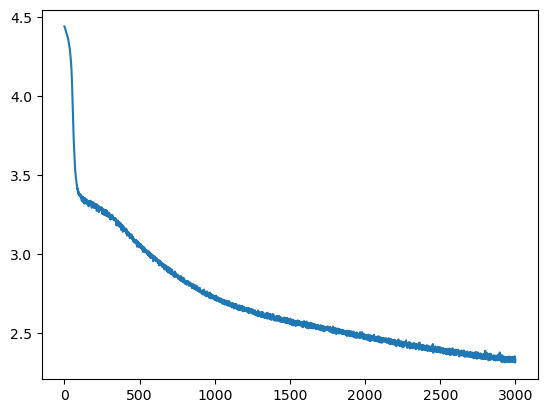

In [55]:
plt.plot(loss_history,label='loss')
plt.show()

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [56]:
# Text generation with different temperature values here

def generate_sample(model, seed_phrase=" мой дядя ", max_length=500, temperature=1.0, device=device):
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    hidden, cell = model.initial_state(batch_size=1)
    model.eval()

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hidden, cell, _ = model(x_sequence[:, i], hidden, cell)

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hidden, cell, logp_next = model(x_sequence[:, -1], hidden, cell)
        # Be really careful here with the model output
        p_next = F.softmax(logp_next / temperature, dim=-1).data.cpu().numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64, device=device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

In [57]:
for temp in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(f'Temperature = {temp}')
    print(generate_sample(model, seed_phrase=" мой дядя ", max_length=100, temperature=temp))
    print("-"*100)

Temperature = 0.1
 мой дядя всет
и сто в поленья в не стовой
и сто в полода стовой польной
в не полень не поровой вере
----------------------------------------------------------------------------------------------------
Temperature = 0.2
 мой дядя стом
и сто в серит постоловой верень
и следный не серень поленья,
и сто слого постовой вер
----------------------------------------------------------------------------------------------------
Temperature = 0.5
 мой дядя оне нем
у полого отодный белен,
го зав в дера сто мней не даги
и не с пострали не слосит
б
----------------------------------------------------------------------------------------------------
Temperature = 1.0
 мой дядя стравоюй
ономок ятна; труго
ил иною ускужит,
в свасчуты лак
и длкато нружже,
и не цеслял я
----------------------------------------------------------------------------------------------------
Temperature = 2.0
 мой дядя дречв цы.
й
он-бля),-дофмыж о-й цжхидяби тларужвы жинебю.
люсворве,»!…н, пужвог—
давься;
у
-

In [ ]:
#при Temperature = 2.0 визуально текст как набор бессвязных букв, очень много знаков препинания 
#при оставшихся Temperature текст приемлимый, визуально читабельный 

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [58]:
torch.save(model, 'lstm')
model = torch.load('lstm')

print(generate_sample(model, seed_phrase=" мой дядя самых честных ", max_length=300, temperature=0.8))

 мой дядя самых честных омном
и подие раду хевстазом.




xxi

и судо в моловольки предной
дининья чтых ней во ладина,
ететум? – него гобкужа,
и тоборя бехерья озвова,
блами друглае узвет;
кодыт ссвевеет олен баи,
четвый кусту зал-каствовы
нась ольни де сяон коревою мот обнаены,
но яхоком лом отробо


/var/folders/4v/kcsyrrp95012y8yjjn3d51540000gn/T/ipykernel_7062/4136152054.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('lstm')


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)